<a href="https://colab.research.google.com/github/rajdeepd/tensorflow_2.0_book_code/blob/master/ch08/WGAN_mnist_example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
from matplotlib import pyplot

In [20]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}


In [21]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [35]:
# define the critic model
def make_critic(in_shape=(28,28,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = ClipConstraint(0.01)
    # define model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # scoring, linear activation
    model.add(Flatten())
    model.add(Dense(1))
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

# define the standalone generator model
def make_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # output 28x28x1
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
    return model

In [36]:
# define the combined generator and critic model, for updating the generator
def make_gan(generator, critic):
    # make weights in the critic not trainable
    critic.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the critic
    model.add(critic)
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [37]:
# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # select all of the examples for a given class
    selected_ix = trainy == 7
    X = trainX[selected_ix]
    # expand to 3d, e.g. add channels
    X = expand_dims(X, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [38]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, -1 for 'real'
    y = -ones((n_samples, 1))
    return X, y


In [39]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [40]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels with 1.0 for 'fake'
    y = ones((n_samples, 1))
    return X, y

In [41]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(10 * 10):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [42]:
# create a line plot of loss for the gan and save to file
%matplotlib inline
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    pyplot.plot(d1_hist, label='crit_real')
    pyplot.plot(d2_hist, label='crit_fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    pyplot.show()
    pyplot.savefig('plot_wgan_line_plot_loss.png')
    pyplot.close()

In [43]:
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=64, n_critic=5):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        for _ in range(n_critic):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update critic model weights
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            c1_tmp.append(c_loss1)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update critic model weights
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
            c2_tmp.append(c_loss2)
        # store critic loss
        c1_hist.append(mean(c1_tmp))
        c2_hist.append(mean(c2_tmp))
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = -ones((n_batch, 1))
        # update the generator via the critic's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        g_hist.append(g_loss)
        # summarize loss on this batch
        print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
        # evaluate the model performance every 'epoch'
        if (i+1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
    # line plots of loss
    plot_history(c1_hist, c2_hist, g_hist)

(6265, 28, 28, 1)
>1, c1=-2.074, c2=-0.021 g=0.001
>2, c1=-6.711, c2=0.036 g=-0.007
>3, c1=-9.575, c2=0.078 g=-0.014
>4, c1=-11.688, c2=0.091 g=-0.018
>5, c1=-13.825, c2=0.070 g=-0.022
>6, c1=-15.077, c2=0.074 g=-0.030
>7, c1=-16.856, c2=0.041 g=-0.036
>8, c1=-18.122, c2=0.005 g=-0.042
>9, c1=-19.406, c2=-0.042 g=-0.051
>10, c1=-20.760, c2=-0.100 g=-0.058
>11, c1=-21.216, c2=-0.169 g=-0.067
>12, c1=-22.405, c2=-0.163 g=-0.074
>13, c1=-23.199, c2=-0.105 g=-0.091
>14, c1=-24.025, c2=-0.061 g=-0.101
>15, c1=-24.824, c2=0.047 g=-0.125
>16, c1=-25.644, c2=0.177 g=-0.155
>17, c1=-26.485, c2=0.341 g=-0.202
>18, c1=-26.893, c2=0.538 g=-0.268
>19, c1=-27.408, c2=0.706 g=-0.335
>20, c1=-28.476, c2=0.852 g=-0.397
>21, c1=-28.806, c2=0.940 g=-0.467
>22, c1=-29.678, c2=1.039 g=-0.551
>23, c1=-30.011, c2=1.003 g=-0.621
>24, c1=-30.690, c2=1.167 g=-0.717
>25, c1=-31.279, c2=1.088 g=-0.807
>26, c1=-31.469, c2=0.956 g=-0.923
>27, c1=-32.112, c2=0.694 g=-1.010
>28, c1=-32.289, c2=0.519 g=-1.123
>29, c1=

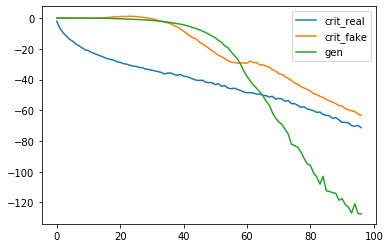

In [44]:
# size of the latent space
latent_dim = 50
# create the critic
critic = make_critic()
# create the generator
generator = make_generator(latent_dim)
# create the gan
gan_model = make_gan(generator, critic)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim)